# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

*   Change the path of the directories according to your drive location.

In [ ]:
import os

root_path = r'/content/drive/MyDrive/MAI/CV/LABS/CV10/TrayDataset'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [ ]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [ ]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

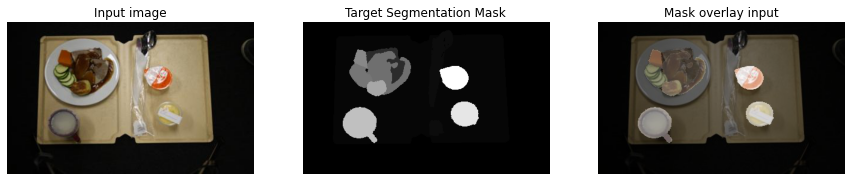

In [ ]:
# solution
import matplotlib.pyplot as plt
from skimage import io
from PIL.ImageOps import autocontrast
from tensorflow.keras.preprocessing.image import load_img

image1 = io.imread(train_img_paths[0])
mask1 = autocontrast(load_img(train_mask_paths[0]))

fig, plots = plt.subplots(1,3, figsize=(15,7))

#image
plots[0].imshow(image1)
plots[0].set_title('Input image')
plots[0].axis('off')

#segmentation mask
plots[1].imshow(mask1)
plots[1].set_title('Target Segmentation Mask')
plots[1].axis('off')

#Mask overlayed on the original image
plots[2].imshow(image1)
plots[2].imshow(mask1, alpha=0.5)
plots[2].set_title('Mask overlay input')
plots[2].axis('off')

fig.show()


# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [ ]:
# solution
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y



# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model
    

In [ ]:
# Free up RAM in case the model definition cells were run multiple times

import keras
keras.backend.clear_session()

In [ ]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [ ]:
# solution
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [ ]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(8, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [ ]:
# solution
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")



*   Instantiate a ModelCheckpoint callback to save only the best model

In [ ]:
# solution
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]



*   Train the model using fit method

In [ ]:
# solution

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 1.8395 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


38/38 [==============================] - 614s 16s/step - loss: 1.8395 - val_loss: 1.6989
Epoch 2/50
38/38 [==============================] - 17s 447ms/step - loss: 0.6304 - val_loss: 6.7585
Epoch 3/50
38/38 [==============================] - 17s 448ms/step - loss: 0.4467 - val_loss: 16.7057
Epoch 4/50
38/38 [==============================] - 17s 445ms/step - loss: 0.3352 - val_loss: 12.8428
Epoch 5/50
38/38 [==============================] - 17s 445ms/step - loss: 0.2785 - val_loss: 12.1609
Epoch 6/50
38/38 [==============================] - 17s 450ms/step - loss: 0.2198 - val_loss: 8.6253
Epoch 7/50
38/38 [==============================] - 17s 448ms/step - loss: 0.2024 - val_loss: 9.0192
Epoch 8/50
38/38 [==============================] - 17s 444ms/step - loss: 0.1761 - val_loss: 11.1072
Epoch 9/50
38/38 [==============================] - 17s 446ms/step - loss: 0.1612 - val_loss: 6.8857
Epoch 10/50
38/38 [==============================] - 17s 448ms/step - loss: 0.1554 - val_loss: 6.78

In [ ]:
model.save('/content/drive/MyDrive/MAI/CV/LABS/CV10')
#model = keras.models.load_model('/content/drive/MyDrive/MAI/CV/LABS/CV10/TrayDataset/saved_model')

# Visualize predictions

*   Generate predictions for all images in the validation set

In [ ]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(1, img_size, test_img_paths, test_mask_paths)

In [ ]:
# solution
val_preds = model.predict(val_gen)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [ ]:
val_masks = np.argmax(val_preds, axis=-1)
print("val_masks shape: ", val_masks.shape)

val_masks shape:  (8, 160, 160)


*   Read the test mask images to create the ground truth

In [ ]:
# solution
test_mask_images = [np.array(autocontrast(load_img(test_mask_paths[i]))) for i in range(len(test_mask_paths))]
test_mask_img = []
for img in test_mask_images:
  img = np.resize(img, (160,160))
  test_mask_img.append(img)

test_mask_img=np.array(test_mask_img)
print('test_mask shape:', test_mask_img.shape)

test_mask shape: (8, 160, 160)


*   For each validation image, find the jaccard similarity score

In [ ]:
# solution
from skimage.io import imread
from skimage.transform import resize
from skimage.util import img_as_int
from sklearn.metrics import jaccard_score

for i in range(len(test_img_paths)):
  g_t = img_as_int(resize(imread(test_img_paths[i], as_gray=True), img_size))
  print(jaccard_score(test_mask_img[i].flatten(), val_masks[i].flatten(), average='micro'))  


0.3276631054869827
0.31822863027806386
0.3536021150033047
0.24280894239871836
0.3529582749781994
0.35385266275318633
0.1352549889135255
0.28523734216934005


*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

 **'average'** parameter determines the type of averaging performed on the data.

 This parameter can be:
* **‘micro’**: Calculate metrics globally by counting the total true positives, false negatives and false positives.
* **‘macro’**: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
* **‘samples’**: Calculate metrics for each instance, and find their average (only meaningful for multilabel classification).
* **‘weighted’**: Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.
* **‘binary’**: Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.
* **None**: The scores for each class are returned.


*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

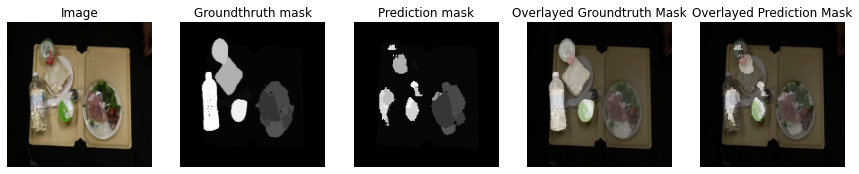

In [ ]:
# solution
import random
i = random.randint(0, len(test_img_paths))
background = resize(imread(test_img_paths[i]), (160, 160))
mask = val_masks[i]
ground_truth = resize(np.array(autocontrast(load_img(test_mask_paths[i]))), (160, 160))

fig, plots =  plt.subplots(1, 5, figsize=(15, 10))

plots[0].imshow(background, cmap='gray')
plots[0].set_title('Image')
plots[0].axis('off')

plots[1].imshow(ground_truth, cmap='gray')
plots[1].set_title('Groundthruth mask')
plots[1].axis('off')

plots[2].imshow(mask, cmap='gray')
plots[2].set_title('Prediction mask')
plots[2].axis('off')

plots[3].imshow(background)
plots[3].imshow(ground_truth, alpha=0.5)
plots[3].set_title('Overlayed Groundtruth Mask')
plots[3].axis('off')

plots[4].imshow(background)
plots[4].imshow(mask, alpha=0.5, cmap='gray')
plots[4].set_title('Overlayed Prediction Mask')
plots[4].axis('off')

plt.show()

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

Other evaluation metrics that we could use are accuracy, precision, recall f1_score, multilabel_confusion_matrix, TP Rate, FP rate...


# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [ ]:
# solution

internet_img = os.path.join(root_path, 'Internet_testing_images')
internet_img_paths = sorted(
    [
        os.path.join(internet_img, fname)
        for fname in os.listdir(internet_img)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(internet_img_paths))

Number of train samples: 5


In [ ]:
val_gen = ImageGenerator(batch_size=batch_size,
                         img_size=img_size,
                         input_img_paths=internet_img_paths,
                         target_img_paths=internet_img_paths)

predictions = model.predict(val_gen)

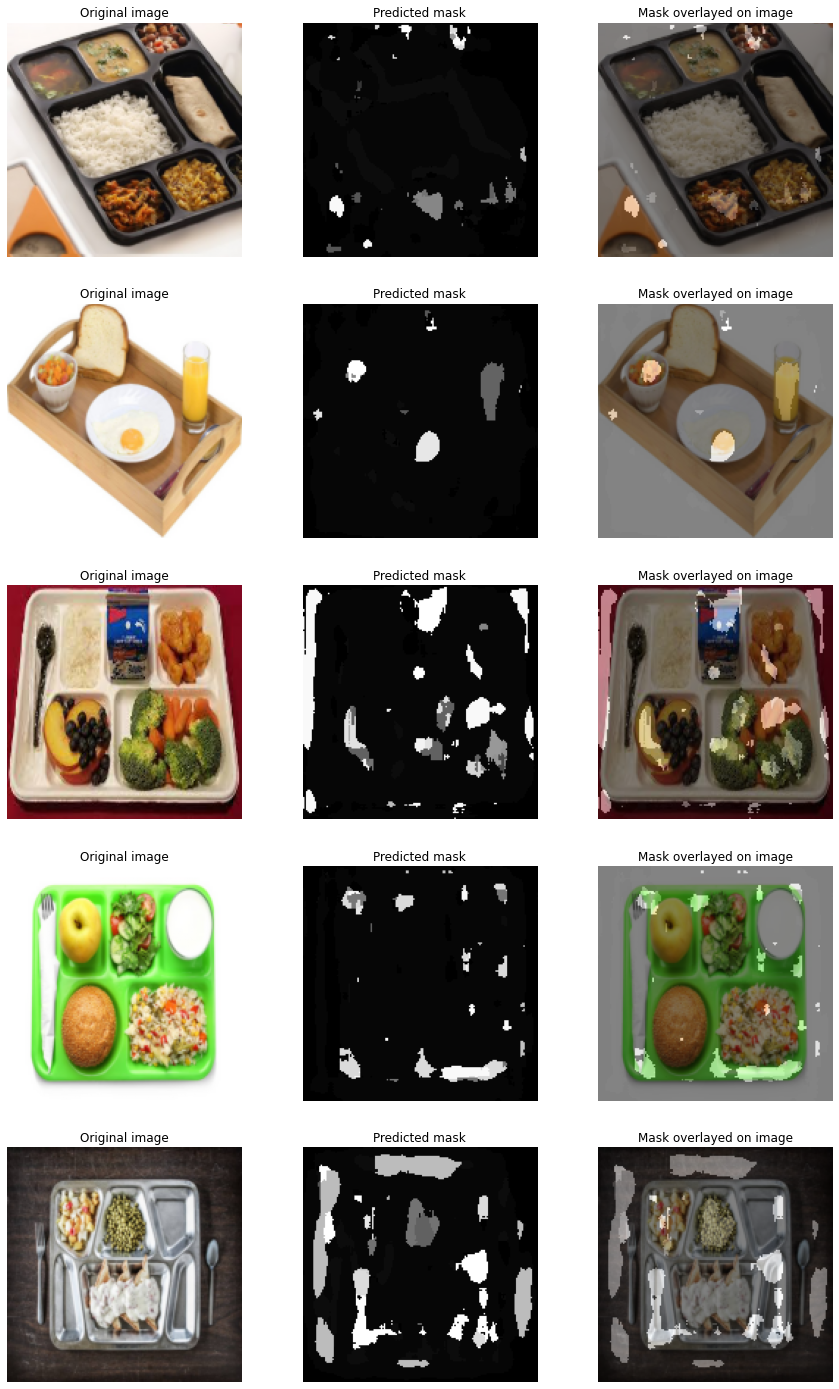

In [ ]:
fig, plots = plt.subplots(5,3, figsize=(15,25))

for i in range(5):

  #original image
  image = io.imread(internet_img_paths[i])
  image = resize(image, (160, 160))
  plots[i][0].imshow(image)
  plots[i][0].set_title('Original image')
  plots[i][0].axis('off')

  #mask
  mask = np.argmax(predictions[i], axis=-1)
  plots[i][1].imshow(mask, cmap='gray')
  plots[i][1].set_title('Predicted mask')
  plots[i][1].axis('off')

  #mask overlayed
  plots[i][2].imshow(image)
  plots[i][2].imshow(mask, cmap='gray', alpha=0.5)  
  plots[i][2].set_title('Mask overlayed on image')
  plots[i][2].axis('off')



*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

* In general, the training dataset does not reflect all the possible objects that may appear in wild images taken the internet. 
* Their shape is misclassified or they are not even identified by the model.



*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

* When we use a trained model in the wild, we have to consider that there can be variations on the quality of the images, on the object (rotations, scaling, illumination, ...), on the perspective of the object (2D images of 3D objects),...
* Making use of data augmentation techniques like noise addition, downsampling, rotations, scaling or/and increasing the size of the dataset.

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

**Semantic segmentation** associates every pixel of an image with a class label such as a person, flower, car and so on. 

In contrast, **instance segmentation** treats multiple objects of the same class as distinct individual instances.

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

Both encoder and decoder are combinational logic circuits, however, one of the crucial difference between encoder and decoder is that an encoder provides binary code as its output. However, a decoder performs inverse operation of the encoder and thus converts the coded input into original data input.


The decoder is again a network (usually the same network structure as encoder but in opposite orientation) that takes the feature vector from the encoder, and gives the best closest match to the actual input or intended output. The encoders are trained with the decoders.

*   What is upsampling?

**Solution**

Upsampling is the process of inserting zero-valued samples between original samples to increase the sampling rate. (This is sometimes called “zero-stuffing”.) This kind of upsampling adds undesired spectral images to the original signal, which are centered on multiples of the original sampling rate.

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

The feature channels simply mean the number of channels at a given point in the network. In the U-Net architecture, the number of channels doubles after the max pooling layers, see for example the first max pooling layer. The input is of size 568 by 568 pixels with 64 (feature) channels, after max pooling this becomes an array of size 284 by 284 pixels with the same 64 channels. The next convolutional layer then keeps the same size, so 284 by 284 pixels, but doubles the number of channels to 128.

This helpful because we can find a smaller objects. 

*   What are some applications of U-Net?

**Solution**

* Medical image analysis
* Others specialitzations that require image classification

...


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Monday, the 3rd of January, 2022**